# Minnesota potential

This notebook is dedicated to the Minnesota (MN) potential. It creates the figures in the manuscript associated with this potential.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")

import numpy as np
import matplotlib.pyplot as plt

from Potential import Potential
from Channel import Channel
from ScatteringExp import ScatteringExp
from Grid import Grid
from RseSolver import RseSolver
from scipy.special import factorial2, spherical_jn
from plots.rc_params import *

## Visualization of the potential (Figure 5)

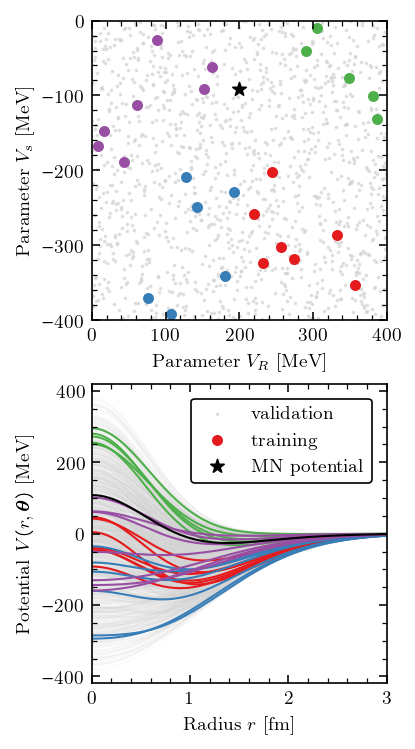

In [92]:
from constants import hbarc, cm
channel = Channel(S=0, L=0, LL=0, J=0, channel=0)
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
potential = Potential(channel, **potentialArgs)
fig, axs = plt.subplots(2, 1, figsize=(6.8*cm,12.5*cm), constrained_layout=True)
np.random.seed(123)

for index, n in enumerate((1250, 25)):
    # randomly sample the 2d parameter space
    # we use 1250 random samples for validation and 25 for training
    param_samples_all = potential.getLecsSample({"V0": (0, 400), "V1": (-400, 0)}, n=n)
    param_samples_plot = np.array([[sample[lec_lbl] for lec_lbl in ("V0", "V1")] for sample in param_samples_all])
    size_marker = [1, 20][index]
    size_line = [0.6, 1.0][index]
    alpha_lines = (0.1, 1.)[index]
        
    # left panel: parameter space
    masks = []
    masks.append(np.logical_and(param_samples_plot[:, 0] > 200, param_samples_plot[:, 1] < -200))
    masks.append(np.logical_and(param_samples_plot[:, 0] < 200, param_samples_plot[:, 1] < -200))
    masks.append(np.logical_and(param_samples_plot[:, 0] > 200, param_samples_plot[:, 1] > -200))
    masks.append(np.logical_and(param_samples_plot[:, 0] < 200, param_samples_plot[:, 1] > -200))
    
    if index == 1:
        alpha = 1 
        label = "training"
    else:
        alpha = 0.6
        label = "validation"

    for i_quadrant in range(4):
        color = colors[i_quadrant] if index == 1 else "lightgray"
        axs[0].scatter(param_samples_plot[masks[i_quadrant],0], param_samples_plot[masks[i_quadrant],1], 
                       alpha=alpha, color=color, s=size_marker, label=label if i_quadrant == 0 else "")

    # right panel: potential V(r)
    grid_plot = np.linspace(0, 4, 200)
    for i_quadrant in range(4): 
        mask = masks[i_quadrant]
        color = colors[i_quadrant] if index == 1 else "lightgray"
        add_lbl_to_legend = True if i_quadrant == 1 else False
        for ilec, lec_sample in enumerate(param_samples_all):
            if not mask[ilec]: 
                continue 
            if add_lbl_to_legend:
                label = ("validation", "training")[index]  
                add_lbl_to_legend = False
            else: 
                label = ""
            vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
            axs[1].plot(grid_plot, vr, color=color, lw=size_line, alpha=alpha_lines, label=label)
        
# plot best_fit value
axs[0].scatter(potential.lecBaseValues["V0"], potential.lecBaseValues["V1"], 
               color="k", s=45, marker="*", label="MN potential")
vr = hbarc * potential.eval(r=grid_plot, lecs=potential.lecBaseValues)
axs[1].plot(grid_plot, vr, color="k", lw=size_line, alpha=alpha_lines, label="MN potential")

# axis labels and more
axs[0].set_xlabel("Parameter $V_R$ [MeV]")
axs[0].set_ylabel("Parameter $V_s$ [MeV]")
axs[0].set_xlim(0,400)
axs[0].set_ylim(-400,0)
axs[1].set_xlim(0,3)
axs[1].set_xlabel("Radius $r$ [fm]")
axs[1].set_ylabel(r"Potential $V(r, \boldsymbol{\theta})$ [MeV]")
axs[1].legend(*axs[0].get_legend_handles_labels())
fig.savefig("figures/minnesota_parameter_space_quadrants.png", dpi=200)

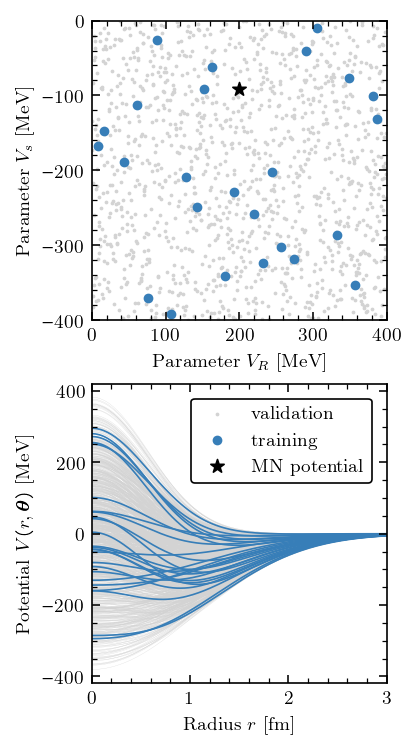

In [ ]:
from constants import hbarc, cm
fig, axs = plt.subplots(2, 1, figsize=(6.8*cm,12.5*cm), constrained_layout=True)
np.random.seed(123)

for index, n in enumerate((1250, 25)):
    param_samples_all = potential.getLecsSample({"V0": (0, 400), "V1": (-400, 0)}, n=n)
    param_samples_plot = np.array([[sample[lec_lbl] for lec_lbl in ("V0", "V1")] for sample in param_samples_all])
    color = ("lightgray", colors[1])[index]
    size = [1, 15][index]
    axs[0].scatter(param_samples_plot[:,0], param_samples_plot[:,1], color=color, s=size, label=("validation", "training")[index])
    
    grid_plot = np.linspace(0, 4, 200)
    size = [1.2, 8][index]
    for lec_sample in param_samples_all:
        vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
        axs[1].plot(grid_plot, vr, color=color, lw=size/10)

axs[0].scatter(potential.lecBaseValues["V0"], 
               potential.lecBaseValues["V1"], color="k", s=45, marker="*", label="MN potential")
axs[0].set_xlabel("Parameter $V_R$ [MeV]")
axs[0].set_ylabel("Parameter $V_s$ [MeV]")
axs[0].set_xlim(0,400)
axs[0].set_ylim(-400,0)
axs[1].set_xlim(0,3)
axs[1].set_xlabel("Radius $r$ [fm]")
axs[1].set_ylabel(r"Potential $V(r, \boldsymbol{\theta})$ [MeV]")
axs[1].legend(*axs[0].get_legend_handles_labels())
fig.savefig("figures/minnesota_parameter_space.png", dpi=200)

## Warm up: solve Schrödinger equation using Runge Kutta

In [2]:
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
# lvalues = [0]
# channels = [Channel(S=0, L=l, LL=l, J=l, channel=0) for l in lvalues]  # only spin 0 

l = 2
channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
potential = Potential(channel, **potentialArgs)
trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

E_MeV = 50
scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)

# generate training data
rmatch = 12
# rmin = np.min((0.1, (factorial2(2*l+1) * 1e-4)**(1/(l+1)) / scattExp.p))
rmin = 1e-12 
assert rmin < 1, "rmin > 1"
# print(f"rmin: {rmin}")
grid = Grid(rmin, rmatch, numIntervals=1, numPointsPerInterval=1000,
            type="linear", test=False) 

In [10]:
inhomogeneous=False
scattSols_numerov = RseSolver.solve(scattExp, grid, testingLecList, 
                            method="Numerov", inhomogeneous=inhomogeneous,
                            asympParam="K", matching=True)
scattSols_rk45 = RseSolver.solve(scattExp, grid, testingLecList, 
                            method="RK45", inhomogeneous=inhomogeneous,
                            asympParam="K", matching=True)

# plt.plot(grid.points, np.real(scattSols_rk45[0].u), label="RK45")
# plt.plot(grid.points, np.real(scattSols_numerov[0].u), label="Numerov")
pr = grid.points * scattExp.p
plt.figure(figsize=(4,3))
# plt.plot(grid.points, spherical_jn(l, pr) * pr, ls=":", label="exact")
plt.plot(grid.points, np.real(scattSols_numerov[0].u-scattSols_rk45[0].u), label="diff")
# plt.plot(grid.points, 
#          np.real(scattSols_numerov[0].u-0*spherical_jn(l, pr) * pr),  
#          label="diff exact Numerov")
# plt.plot(grid.points, 
#          np.real(scattSols_rk45[0].u-0*spherical_jn(l, pr) * pr),  
#          label="diff exact RK")
plt.xlabel("$r$")
plt.ylabel("$y(r)$")
# plt.xlim(-0.1,0.1)
plt.title(f"$\ell = {l}$")
plt.legend()

a = scattSols_numerov[0].Lmatrix.phaseShift
b = scattSols_rk45[0].Lmatrix.phaseShift
print("phaseshifts", a,b, np.abs(a-b))

TypeError: RseSolver.solve() got an unexpected keyword argument 'inhomogeneous'

In [ ]:
inhomogeneous=True
args = dict(asympParam="K", matching=True)
solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=inhomogeneous)
num1  = solver.solve(lecList_=testingLecList, method="Numerov_affine", **args)
num2  = solver.solve(lecList_dict=testingLecList, method="Numerov", **args)
numk  = solver.solve(lecList_dict=testingLecList, method="RK45", **args)
print("diff", np.max(np.abs(num1[0].u-num2[0].u)))
print("diff", np.max(np.abs(numk[0].u-num2[0].u)))

testing


TypeError: RseSolver.solve() got an unexpected keyword argument 'lecList_dict'

In [68]:
solver.solve(lecList_dict=testingLecList, method="Numerov_affine", reduced_output=True, **args)[1]

array([0.12807611])

In [77]:
inhomogeneous=False
args = dict(asympParam="K", matching=True)
solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=inhomogeneous)
num1  = solver.solve(lecList_dict=testingLecList, method="Numerov_affine", **args)
num2  = solver.solve(lecList_dict=testingLecList, method="Numerov", **args)
numk  = solver.solve(lecList_dict=testingLecList, method="RK45", **args)
print("diff", np.max(np.abs(num1[0].u-num2[0].u)))
print("diff", np.max(np.abs(numk[0].u-num2[0].u)))
np.max(np.abs(num1[0].uprime - (num1[0].chiprime + num1[0].free_solutions_F_G(derivative=True)[:,0]) / scattExp.p))

testing
diff 4.166389455662056e-13
diff 4.797976183024133e-10


1.1102230246251565e-16

In [13]:
inhomogeneous=True
args = dict(lecList=testingLecList, asympParam="K", matching=True)
solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=inhomogeneous)
num1  = solver.solve(method="Numerov_affine", **args)
num2  = solver.solve(method="Numerov", **args)
numk  = solver.solve(method="RK45", **args)
print("diff", np.max(np.abs(num1[0].u-num2[0].u)))
print("diff", np.max(np.abs(numk[0].u-num2[0].u)))
np.max(np.abs(num1[0].uprime - (num1[0].chiprime + num1[0].free_solutions_F_G(derivative=True)[:,0]) / scattExp.p))

testing
diff 1.202926647181357e-13
diff 1.4836676331952958e-10


1.1102230246251565e-16

In [33]:
inhomogeneous=False
args = dict(asympParam="K", matching=True)
solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=inhomogeneous)
num1  = solver.solve(lecList_dict=testingLecList, method="Numerov_affine", **args)
num2  = solver.solve(lecList_dict=testingLecList, method="Numerov", **args)
numk  = solver.solve(lecList_dict=testingLecList, method="RK45", **args)
print("diff", np.max(np.abs(num1[0].u-num2[0].u)))
print("diff", np.max(np.abs(numk[0].u-num2[0].u)))

testing
diff 4.166389455662056e-13
diff 4.797976183024133e-10


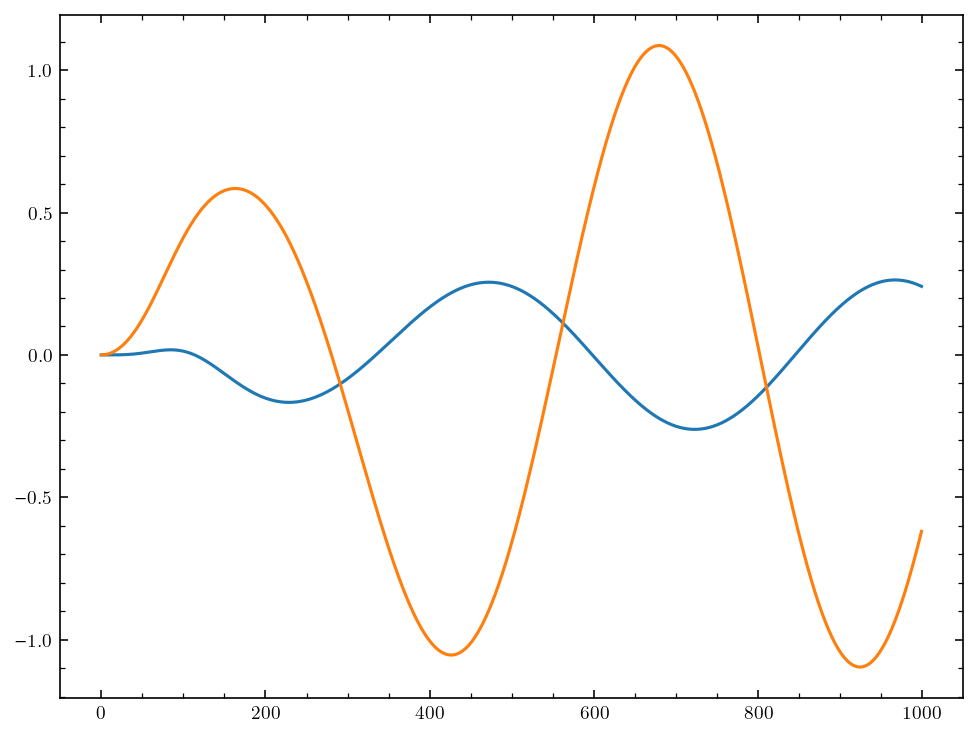

In [ ]:
plt.plot(num1[0].chiprime)
plt.plot(num1[0].uprime)

In [ ]:
ab = np.loadtxt("orig_ab.csv")
rhs = np.loadtxt("orig_s.csv")
A = np.loadtxt("class_A.csv")
s = np.loadtxt("class_s.csv")
print(np.max(np.abs(A-ab)))
print(np.max(np.abs(s-rhs)))

4.440892098500626e-16
5.551115123125783e-17


In [ ]:
from Numerov import diag_ord_form_to_mat
np.linalg.cond(diag_ord_form_to_mat(A, (2,0), toarray=True)[1:,1:])

367172.8170310892

In [ ]:
# np.abs(num[0].u-num2[0].u)#

In [ ]:
nb = 5
ntheta = 10
ngrid = 1000

X = np.ones((ngrid, nb))
At = np.ones((ngrid, ngrid, ntheta))

print("Xshape", X.shape)
print("Atshape", At.shape)

%timeit np.tensordot(X.T, np.tensordot(At, X, axes=[1,0]), axes=[1,0]).shape

Xshape (1000, 5)
Atshape (1000, 1000, 10)
37.8 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
nb = 5
ntheta = 10
ngrid = 1000

X = np.ones((ngrid, nb))
At = np.ones((ntheta, ngrid, ngrid))
lec = np.ones(ntheta)

print("Xshape", X.shape)
print("Atshape", At.shape)

%timeit (X.T @ At @ X).shape
np.tensordot(lec, (X.T @ At @ X), axes=1).shape

Xshape (1000, 5)
Atshape (10, 1000, 1000)
4.8 ms ± 228 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


(5, 5)

## Illustration of the greedy algorithm in 1D (Figure 6)

In [ ]:
from NumerovEmulator import AffineGROMNoMatch
args = dict(scattExp=scattExp, 
            grid=grid, 
            free_lecs={"V1": (-400, 0)}, 
            num_snapshots_init=2, 
            num_snapshots_max=200, 
            approach="greedy", 
            pod_rcond=1e-10, 
            init_snapshot_lecs=None,
            greedy_max_iter=3, 
            mode="linear",
            seed=10203
            )
greedy_grom = AffineGROMNoMatch(emulator_training_mode="grom", **args)
greedy_lspg = AffineGROMNoMatch(emulator_training_mode="lspg", **args)

POD[ Y ]: compression rate is 33.3 %; dim: (800, 6)
snapshot idx already included in basis: {35, 149}
now greedily improving the snapshot basis:
	iteration #1 of max 3:
	available candidate snapshot idx to be added: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


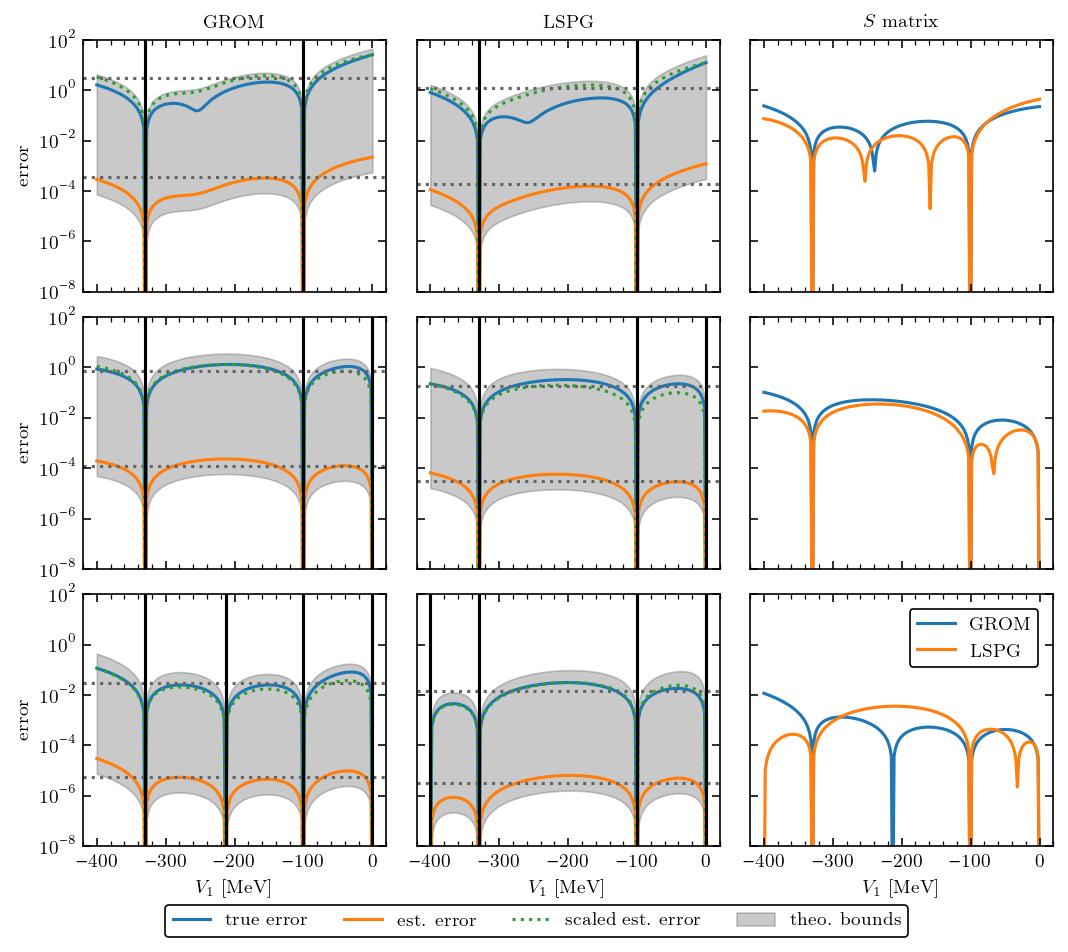

In [ ]:
from constants import cm
mpl.rcParams['figure.constrained_layout.use'] = False
num_iter = len(greedy_lspg.greedy_logging)
V0_arr = greedy_lspg.lec_all_samples[:,2]
fig, axs = plt.subplots(num_iter, 3, sharex=True, sharey=True,
                        figsize=(18*cm,16*cm), layout=None)

plt.subplots_adjust(left=0.07, right=0.99, 
                    top=0.96, bottom=0.1, 
                    wspace=0.1, hspace=0.1)
for ax in axs[-1,:]:
    ax.set_xlabel("$V_1$ [MeV]")
for ax in axs[:, 0]:
    ax.set_ylabel("error")
for ax, title in zip(axs[0,:], ("GROM", "LSPG", "$S$ matrix")):
    ax.set_title(title)

axs[0,0].set_ylim(1e-8, 1e2)
# axs[0,0].set_xlim(V0_arr[0], V0_arr[-1])

for niter in range(num_iter):
    for irom_lbl, rom_lbl in enumerate(("grom", "lspg")):
        rom = greedy_grom if rom_lbl == "grom" else greedy_lspg
        ax = axs[niter, irom_lbl]
        [snapshot_idxs, fom_sol, emulated_sol, 
        romErrors, realErrors, estErrBounds,
        coercivity_constant] = rom.greedy_logging[niter]
        ax.semilogy(V0_arr, realErrors, label=f"true error")
        ax.semilogy(V0_arr, romErrors, ls="-", label=f"est. error")
        ax.semilogy(V0_arr, coercivity_constant*romErrors, 
                    ls=":", label=f"scaled est. error")
        
        # ax.semilogy(V0_arr, estErrBounds[:,0], label=f"lower bound")
        # ax.semilogy(V0_arr, estErrBounds[:,1], label=f"upper bound")
        ax.fill_between(V0_arr, estErrBounds[:,0], estErrBounds[:,1], 
                        alpha=0.3, color='0.3',
                        zorder=0, label="theo. bounds")

        Smats_emul = greedy_lspg.get_S_matrix(emulated_sol)
        Smats_fom = greedy_lspg.get_S_matrix(fom_sol)
        axs[niter, 2].semilogy(V0_arr, np.abs(Smats_emul - Smats_fom), label=rom_lbl.upper())
        # ax.semilogy(V0_arr, romErrors, ls="-", label=f"est. error")
    
        for err in (romErrors, realErrors):
            ax.axhline(np.mean(err), ls=":", c='0.4', label="")
            # ax.set_title(f"Estimated mean error: {np.mean(realErrors):.2e}")

        for idx in snapshot_idxs:
            ax.axvline(V0_arr[idx], c="k", label="")
    
    axs[-1,0].legend(bbox_to_anchor =(0.5, 0.02), loc='center', ncol=4, 
                     bbox_transform=fig.transFigure)
    # axs[0,0].legend(loc='lower left', ncol=4, bbox_to_anchor =(1.5,2.65))
    axs[-1,-1].legend(loc='best', ncol=1)
    fig.savefig(f"greedy_MN_potential_1S0.pdf")